# Introdution to Artificial Neural Networks with Keras

In [1]:
# FIXME: meke autocompletion working again
%config Completer.use_jedi = False

## The Perceptron
**Forward step** is $h_{\mathbf{W}, \mathbf{b}} = \phi(\mathbf{X}\mathbf{W} + \mathbf{b})$ (assuming the addition is broadcasted).

**Learning step** is $w_{i,j}^{(\text{next})} = w_{i,j} + \eta (y_j - \hat{y}_j) x_i$ where:
* $x_i$ is the $i$-th input
* $y_j$ is the $j$-th target
* $\hat{y}_j$ is the $j$-th predicted value
* $\eta$ is the learning rate

The learning is basically a gradient descent with constant learning rate and specific gradient.

It can be shown that for linearly separable dataset this algorightm converges and finds a separating hyper-plane.

In [2]:
import numpy as np

from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

# Load the IRIS dataset
iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int)

# Train Perceptron with single unit
per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

# Make a prediction
per_clf.predict([[2, 0.5]])

array([1])

## Activation functions

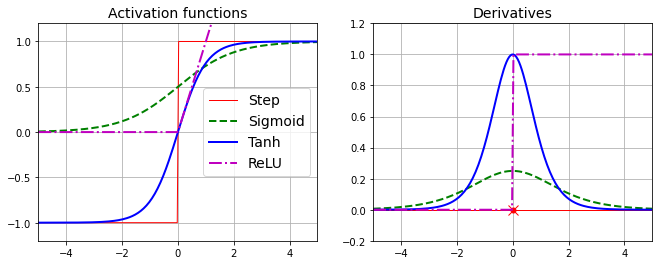

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

# Define the input space for activation functions
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

# Plot activation functions
plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

# Plot first derivatives (approx.) of activation functions above
plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

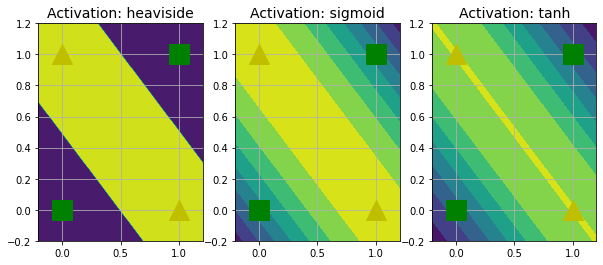

In [4]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

# Crate a space for the XOR problem
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

plt.figure(figsize=(10,4))

def plot_xor_activation(i, activation):
    # Plot contour of activation function on the XOR space
    plt.subplot(131 + i)
    plt.contourf(x1, x2, mlp_xor(x1, x2, activation))
    plt.plot([0, 1], [0, 1], "gs", markersize=20)
    plt.plot([0, 1], [1, 0], "y^", markersize=20)
    plt.title(f"Activation: {activation.__name__}", fontsize=14)
    plt.grid(True)

for i, activation in enumerate([heaviside, sigmoid, np.tanh]):
    plot_xor_activation(i, activation)

plt.show()

## Regression MLPs
* **Inputs**: one neuron per input feature
* **Outputs**: one neuron per output dimension
* **# hidden layers**: typically 1-5
* **# neurons per hidden layer**: typically 10-100
* **Activation in hidden layer**: *ReLU*
* **Activation in output layer**: None or *ReLU*/*softplus* (positive output) or *logistic*/*tanh* (interval bounded output)
* **Loss function**: *MSE* or *mean absolute error (MAE)* / *Huber loss* (if outliers)

## Classification MLPs
| Hyperparameter          | Binary classification | Multilabel binary classification | Multiclass classification |
|-------------------------|-----------------------|----------------------------------|---------------------------|
| Input and hidden layers | Sane as regression    | Same as regression               | Same as regression        |
| # output neurons        | 1                     | 1 per label                      | 1 per class               |
| Output layer activation | Logistic              | Logistic                         | Softmax                   |
| Loss function           | Cross entropy         | Cross entropy                    | Cross entropy             |

## Implementing MLPs with Keras
**Keras (multibackend)** was originally an open-source research project that defines a generic API for deep learning models that supports multiple execution backends:
* *theano*
* *mxnet*
* *tensorflow*

`tf.keras` is *TensorFlow*'s bundeled implementation of Keras (using TF backend of course) which comes with some extra TF features.

An alternative, but nowadays very similar, library is Facebook's **PyTorch**.

### Building an Image Classifier Using the Sequential API

In [5]:
import tensorflow as tf
from tensorflow import keras

# Load Fashin MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

X_train_full.shape

(60000, 28, 28)

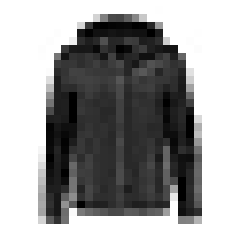

In [6]:
# Create a validation set and scale inputs to [0, 1] range
max_value = 255.0
val_train_split = 5000
X_valid, X_train = X_train_full[:val_train_split] / max_value, X_train_full[val_train_split:] / max_value
y_valid, y_train = y_train_full[:val_train_split], y_train_full[val_train_split:]
X_test = X_test / max_value

plt.imshow(X_train[0], cmap="binary")
plt.axis("off")
plt.show()

In [7]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [8]:
# Define class names to be used for corresponding class labels
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

class_names[y_train[0]]

'Coat'

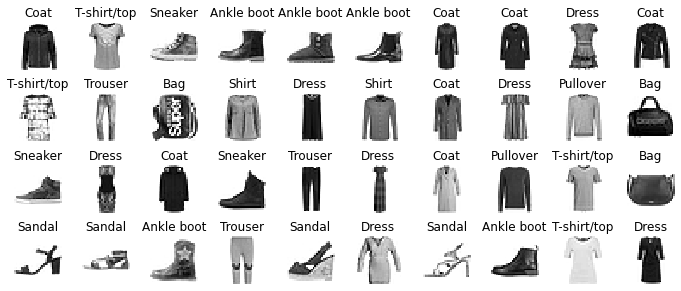

In [9]:
# Show some images

n_rows = 4
n_cols = 10

plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=input_shape))
model.add(keras.layers.Dense(300, activation=keras.activations.relu))
model.add(keras.layers.Dense(100, activation=keras.activations.relu))
model.add(keras.layers.Dense(10, activation=keras.activations.softmax))

In [11]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

# Equivalent to above, also activations can be referred to just by name, e.g. `"relu"`
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


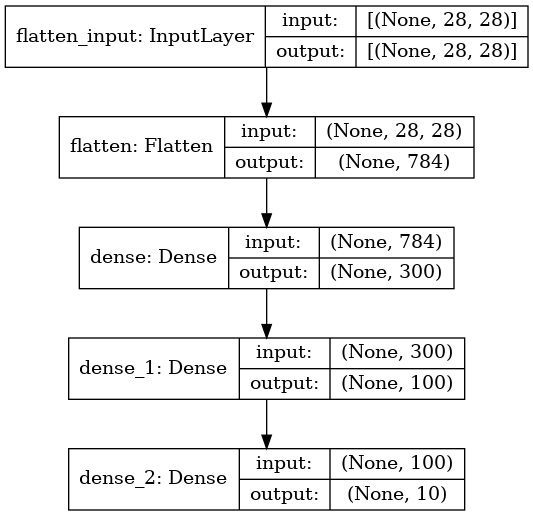

In [12]:
import os

keras.utils.plot_model(model, os.path.join("data", "my_fashion_mnist_model.png"), show_shapes=True)

In [13]:
model.layers

In [14]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [15]:
model.get_layer(hidden1.name) is hidden1

True

In [16]:
weights, biases = hidden1.get_weights()
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [17]:
weights.shape

(784, 300)

In [18]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [19]:
biases.shape

(300,)

In [20]:
# Compile the model to set the loss function and other metadata
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="sgd",
    metrics=["accuracy"],
)

# Train the model on the trainng set for 30 epochs and validate on the validation set
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0187 - accuracy: 0.6805 - val_loss: 0.5213 - val_accuracy: 0.8226
Epoch 2/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5028 - accuracy: 0.8262 - val_loss: 0.4351 - val_accuracy: 0.8538
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4484 - accuracy: 0.8421 - val_loss: 0.5363 - val_accuracy: 0.7984
Epoch 4/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4210 - accuracy: 0.8525 - val_loss: 0.3914 - val_accuracy: 0.8652
Epoch 5/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.4060 - accuracy: 0.8580 - val_loss: 0.3744 - val_accuracy: 0.8696
Epoch 6/30
1719/1719 [==============================] - 4s 3ms/step - loss: 0.3753 - accuracy: 0.8676 - val_loss: 0.3713 - val_accuracy: 0.8726
Epoch 7/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3654 - accuracy: 0.8707 - val_loss: 0.3613 - val_accuracy:

In [21]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

In [23]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

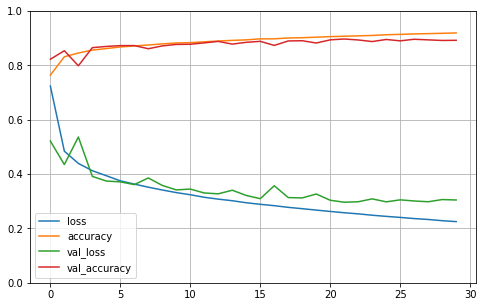

In [25]:
import pandas as pd

history_df = pd.DataFrame(history.history)

# Plot learning curves
history_df.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [26]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3388 - accuracy: 0.8818


[0.3388163447380066, 0.8817999958992004]

In [27]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.03, 0.  , 0.96],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [31]:
# y_pred = model.predict_classes(X_new)  # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

array([9, 2, 1])

In [33]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [34]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

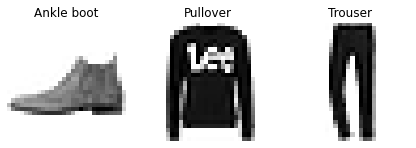

In [35]:
plt.figure(figsize=(7.2, 2.4))

for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[index]], fontsize=12)

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()